In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt

# Definições iniciais

In [8]:
h = 0.1
k = 1
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.5
X_nb = 1e-4
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h)))+1
size_y = int(((y_dom[1] - y_dom[0]) / (h)))+1
size_t = int(((t_dom[1] - t_dom[0]) / (k)))+1

print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

print(
    "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
        size_t,
        size_x,
        size_y,
    )
)

CFL = (Db * k) / ((2 * (h * h)))

print("CFL: ", CFL, "\n")

if CFL >= 1:
    print("Criterio CFL não satisfeito\n")

    sys.exit(400)

# Computing FDM model

struct_name = (
    "h--"
    + str(h)
    + "__k--"
    + str(k)
    + "__Db--"
    + str(Db)
    + "__Dn--"
    + str(Dn)
    + "__phi--"
    + str(phi)
    + "__ksi--"
    + str(ksi)
    + "__cb--"
    + str(cb)
    + "__lambd_nb--"
    + str(lambd_nb)
    + "__mi_n--"
    + str(mi_n)
    + "__lambd_bn--"
    + str(lambd_bn)
    + "__y_n--"
    + str(y_n)
    + "__Cn_max--"
    + str(Cn_max)
    + "__X_nb--"
    + str(X_nb)
    + "__x_dom_min--"
    + str(x_dom[0])
    + "__x_dom_max--"
    + str(x_dom[-1])
    + "__y_dom_min--"
    + str(y_dom[0])
    + "__y_dom_max--"
    + str(y_dom[-1])
    + "__t_dom_min--"
    + str(t_dom[0])
    + "__t_dom_max--"
    + str(t_dom[-1])
)

print("struct_name: ", struct_name)

Size x = 11, y = 11 
 
Steps in time = 11
Steps in space_x = 11
Steps in space_y = 11

CFL:  0.004999999999999999 

struct_name:  h--0.1__k--1__Db--0.0001__Dn--0.0001__phi--0.2__ksi--0.0__cb--0.15__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__Cn_max--0.5__X_nb--0.0001__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10


# Análise de nullclines

# PINN

In [12]:
with open("fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cb_fdm = pk.load(f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cn_fdm = pk.load(f)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t + 1, endpoint=True)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_t + 1, endpoint=True)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_t + 1, endpoint=True)

tt, xx, yy = np.meshgrid(t_np, x_np, y_np)

data_input_np = np.array([Cn_fdm.flatten(), Cb_fdm.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t_tc = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    x_tc = (
        torch.tensor(xx, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    y_tc = (
        torch.tensor(yy, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t_tc = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    x_tc = torch.tensor(xx, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y_tc = torch.tensor(yy, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cpu


In [13]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [14]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [16]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](3, int(out_neurons)))

                else:
                    modules.append(nn.Linear(3, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [17]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [18]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset, 0).values
        dt_max = torch.max(dataset, 0).values
        normalized = (dataset - dt_min) / (dt_max - dt_min)

    return normalized.requires_grad_(True), dt_min, dt_max

In [19]:
def normalize_data_input(data_input, steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps, steps, 2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i], 0).values
            dt_max = torch.max(dataset[i], 0).values
            normalized[i] = (dataset[i] - dt_min) / (dt_max - dt_min)

    return normalized.reshape((steps) * (steps), 2)

In [20]:
def rescale(dataset, dt_min, dt_max):
    return (dt_max - dt_min) * dataset + dt_min

In [21]:
def shuffle_data(x, y, z):
    Data_num = np.arange(x.shape[0])
    np.random.shuffle(Data_num)

    return x[Data_num], y[Data_num], z[Data_num]

In [22]:
def train_test_split(x, y, z, test_size=0.5, shuffle=True):
    with torch.no_grad():
        if shuffle:
            x, y, z = shuffle_data(x, y, z)
        if test_size < 1:
            train_ratio = len(x) - int(len(x) * test_size)
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            y_train, y_test = y[:train_ratio], y[train_ratio:]
            z_train, z_test = z[:train_ratio], z[train_ratio:]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )
        elif test_size in range(1, len(x)):
            x_train, x_test = x[test_size:], x[:test_size]
            y_train, y_test = y[test_size:], y[:test_size]
            z_train, z_test = z[test_size:], z[:test_size]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )

In [ ]:
def gerenate_training_points(num_points):
    x = torch.rand(num_points, 1)
    y = torch.rand(num_points, 1)
    t = torch.rand(num_points, 1)
    
    return x, y, t

tensor([0., 1., 0., 1.])

In [51]:
x_boundary = torch.tensor([0.0, 1.0]).repeat(4 // 2)
y_boundary = torch.rand(4)

if torch.rand(1) > 0.5:
    x_boundary, y_boundary = y_boundary, x_boundary
    n = torch.tensor([[0.0, -1.0],[0.0, 1.0]]).repeat(4 // 2,1)
else:
    n = torch.tensor([[-1.0, 0.0],[1.0, 0.0]]).repeat(4 // 2,1)
    
print(x_

tensor([0., 1., 0., 1.])

In [52]:
n

tensor([[-1.,  0.],
        [ 1.,  0.],
        [-1.,  0.],
        [ 1.,  0.]])

In [ ]:
def gerenate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0, 1.0]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary

    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)

In [ ]:
def initial_condition(x, y):

    Cl = torch.full_like(x, 0)

    Cp = torch.full_like(x, 0)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.6)) and ((yy >= 0.5) and (yy <= 0.6)):
            Cp[i] = 0.2

    return Cl, Cp

In [ ]:
def boundary_condition(self, x_b, y_b, t_b, n):

    input_data = torch.cat([x_b, y_b, t_b], dim=1)

    Cp, Cl = self.model(input_data).tensor_split(2, dim=1)

    dCp_dx = torch.autograd.grad(
        Cp,
        x_b,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )
    dCl_dx = torch.autograd.grad(
        Cl,
        x_b,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    Cl_boundary = (
        torch.mul(
            ((self.Dn * dCl_dx[0]) - self.X_nb * torch.mul(Cl, dCp_dx[0])), nx
        )
        - custom_value
    )
    
    Cp_boundary = torch.mul((self.Db * dCp_dx[0]), n) - custom_value

    return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [ ]:
def pde(self, x, y, t):
    input_data = torch.cat([x, y, t], dim=1)

    Cl, Cp = self.model(input_data).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = self.cp * Cp
    rb = self.lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = self.Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = self.y_n * torch.mul(Cp, (self.C_nmax - Cl))
    rn = self.lambd_bn * torch.mul(Cl, Cp) + self.mi_n * Cl

    Cl_eq = (
        self.Dn * (dCl_dx_2 + dCl_dy_2)
        - self.X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [16]:
def train(
    n_epochs,
    batch_size,
    decay_rate,
    model,
    initial,
    device,
    data_input,
    t,
    norm_weights=None,
    validation=None,
):
    dt_min, dt_max = norm_weights if norm_weights else (0, 1)

    print(dt_min, dt_max)

    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )

    if validation:
        train_data, test_data, train_t, test_t, train_initial, test_initial = (
            train_test_split(data_input, t, initial, test_size=validation)
        )
        train_data_input = torch.cat([train_t, train_initial], dim=1)
        test_data_input = torch.cat([test_t, test_initial], dim=1)

    else:
        train_data = data_input
        test_data = None
        train_data_input = torch.cat([t, initial], dim=1)
        test_data_input = None
        train_t = t
        test_t = None
        train_initial = initial
        test_initial = None

    C_pde_loss_it = torch.zeros(n_epochs).to(device)
    C_data_loss_it = torch.zeros(n_epochs).to(device)
    C_initial_loss_it = torch.zeros(n_epochs).to(device)
    C_initial = initial_condition(train_initial).to(device)
    val_loss_it = torch.zeros(n_epochs).to(device)

    for epoch in range(n_epochs):
        for i in range(0, len(train_t), batch_size):
            t_initial = torch.zeros_like(train_t[i : i + batch_size])

            mesh_ini = torch.cat([t_initial, train_initial[i : i + batch_size]], dim=1)
            C_initial_pred = model(mesh_ini)

            loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

            Cl, Cp = model(train_data_input[i : i + batch_size]).split(1, dim=1)

            Cl_eq = (y_n * Cp * (C_nmax - Cl) - lambd_bn * Cp * Cl - mi_n * Cl) / (
                phi * (dt_max - dt_min)
            )
            Cp_eq = (cb * Cp - lambd_nb * Cl * Cp) / (phi * (dt_max - dt_min))

            pde_pred = torch.cat([Cl_eq, Cp_eq], dim=1)

            loss_pde = loss_fn(
                pde(
                    train_t[i : i + batch_size],
                    train_initial[i : i + batch_size],
                    model,
                ),
                pde_pred,
            )

            C_pred = torch.cat([Cl, Cp], dim=1)

            loss_data = loss_fn(train_data[i : i + batch_size], C_pred)

            loss = 15 * loss_initial + loss_pde + 40 * loss_data

            if validation:
                with torch.no_grad():
                    val_loss = loss_fn(test_data, model(test_data_input))
            # val_loss = torch.tensor([0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        C_pde_loss_it[epoch] = loss_pde.item()
        C_initial_loss_it[epoch] = loss_initial.item()
        C_data_loss_it[epoch] = loss_data.item()
        val_loss_it[epoch] = val_loss.item() if validation else 0

        if (epoch % 100) == 0:
            print(
                f"Finished epoch {epoch+1}, latest loss {loss}, validation loss {val_loss.item()}"
                if validation
                else f"Finished epoch {epoch+1}, latest loss {loss}"
            )

    return model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it, val_loss_it

In [17]:
decay_rate = 0.999
n_epochs = 300
batch_size = 1000

model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it, val_loss_it = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial=initial,
    device=device,
    data_input=data_input,
    t=t,
    validation=0.1,
)

0 1
Finished epoch 1, latest loss 4.448906898498535, validation loss 0.08041059225797653
Finished epoch 101, latest loss 0.0029682088643312454, validation loss 6.0761001805076376e-05
Finished epoch 201, latest loss 0.0014791107969358563, validation loss 3.428360287216492e-05


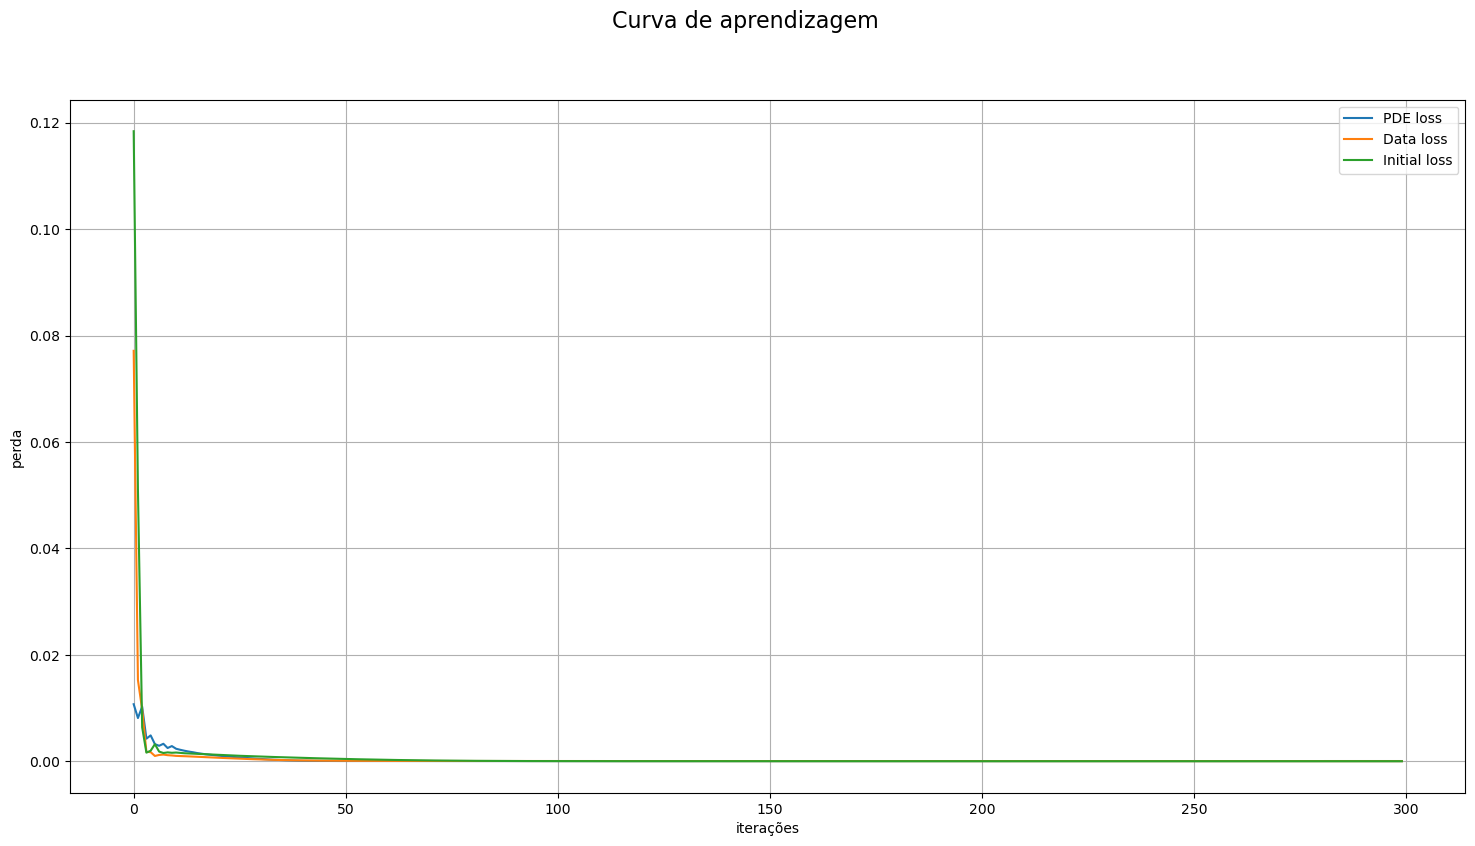

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

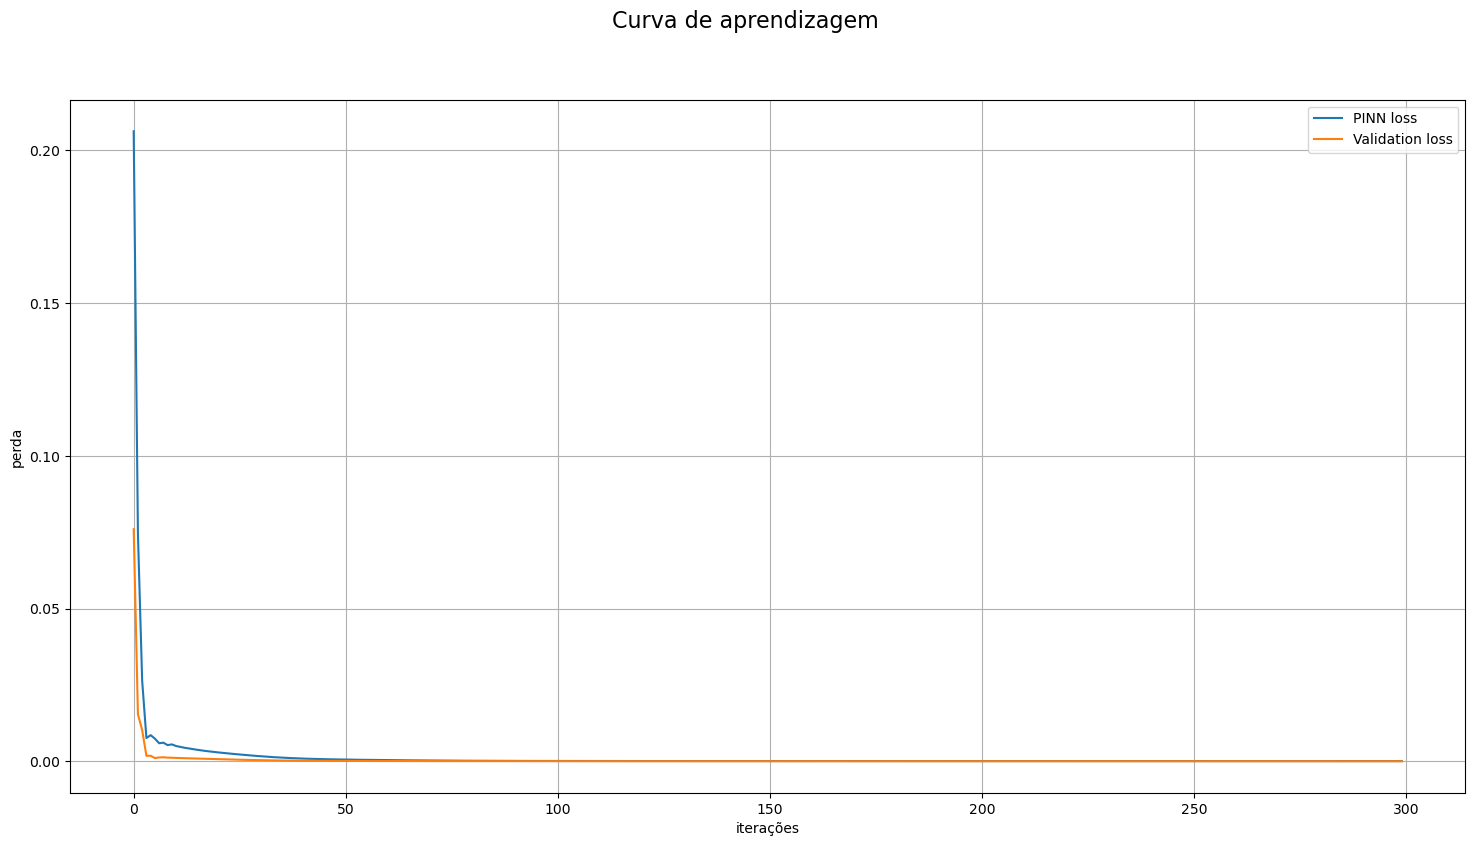

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [20]:
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([t, initial], dim=1).to("cpu")

for i in range(10):
    fdm_start = time.time()

    for ini in initial_list:
        _, _ = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            ini,
        )

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [21]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

In [22]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [23]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.0045312573
Erro absoluto máximo 0.029005468
Speed Up: 3.7759748569853437 +/-1.8600189623443617


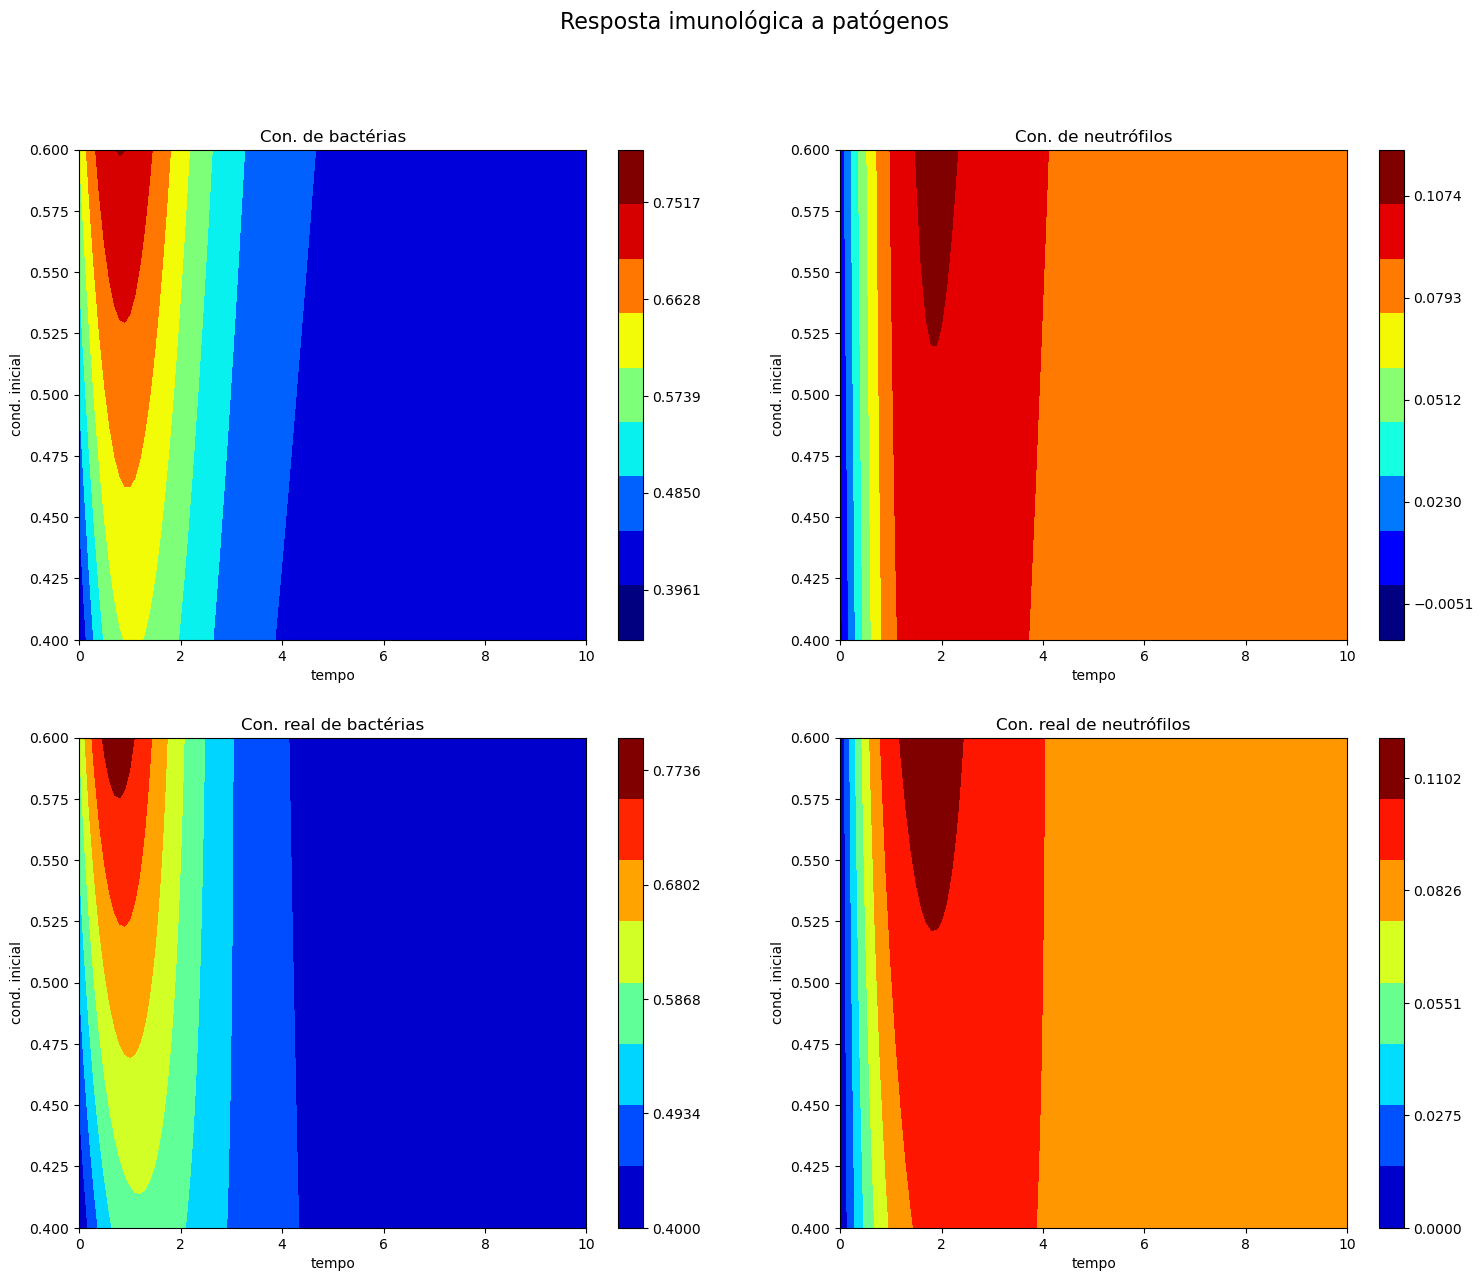

In [24]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)

fig = plt.figure(figsize=[18, 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

vmin = np.min(Cp_pinn_np)
vmax = np.max(Cp_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

vmin = np.min(Cl_pinn_np)
vmax = np.max(Cl_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

vmin = np.min(Cp_old)
vmax = np.max(Cp_old)

contour = ax.contourf(
    tt,
    ii,
    Cp_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

vmin = np.min(Cl_old)
vmax = np.max(Cl_old)

contour = ax.contourf(
    tt,
    ii,
    Cl_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

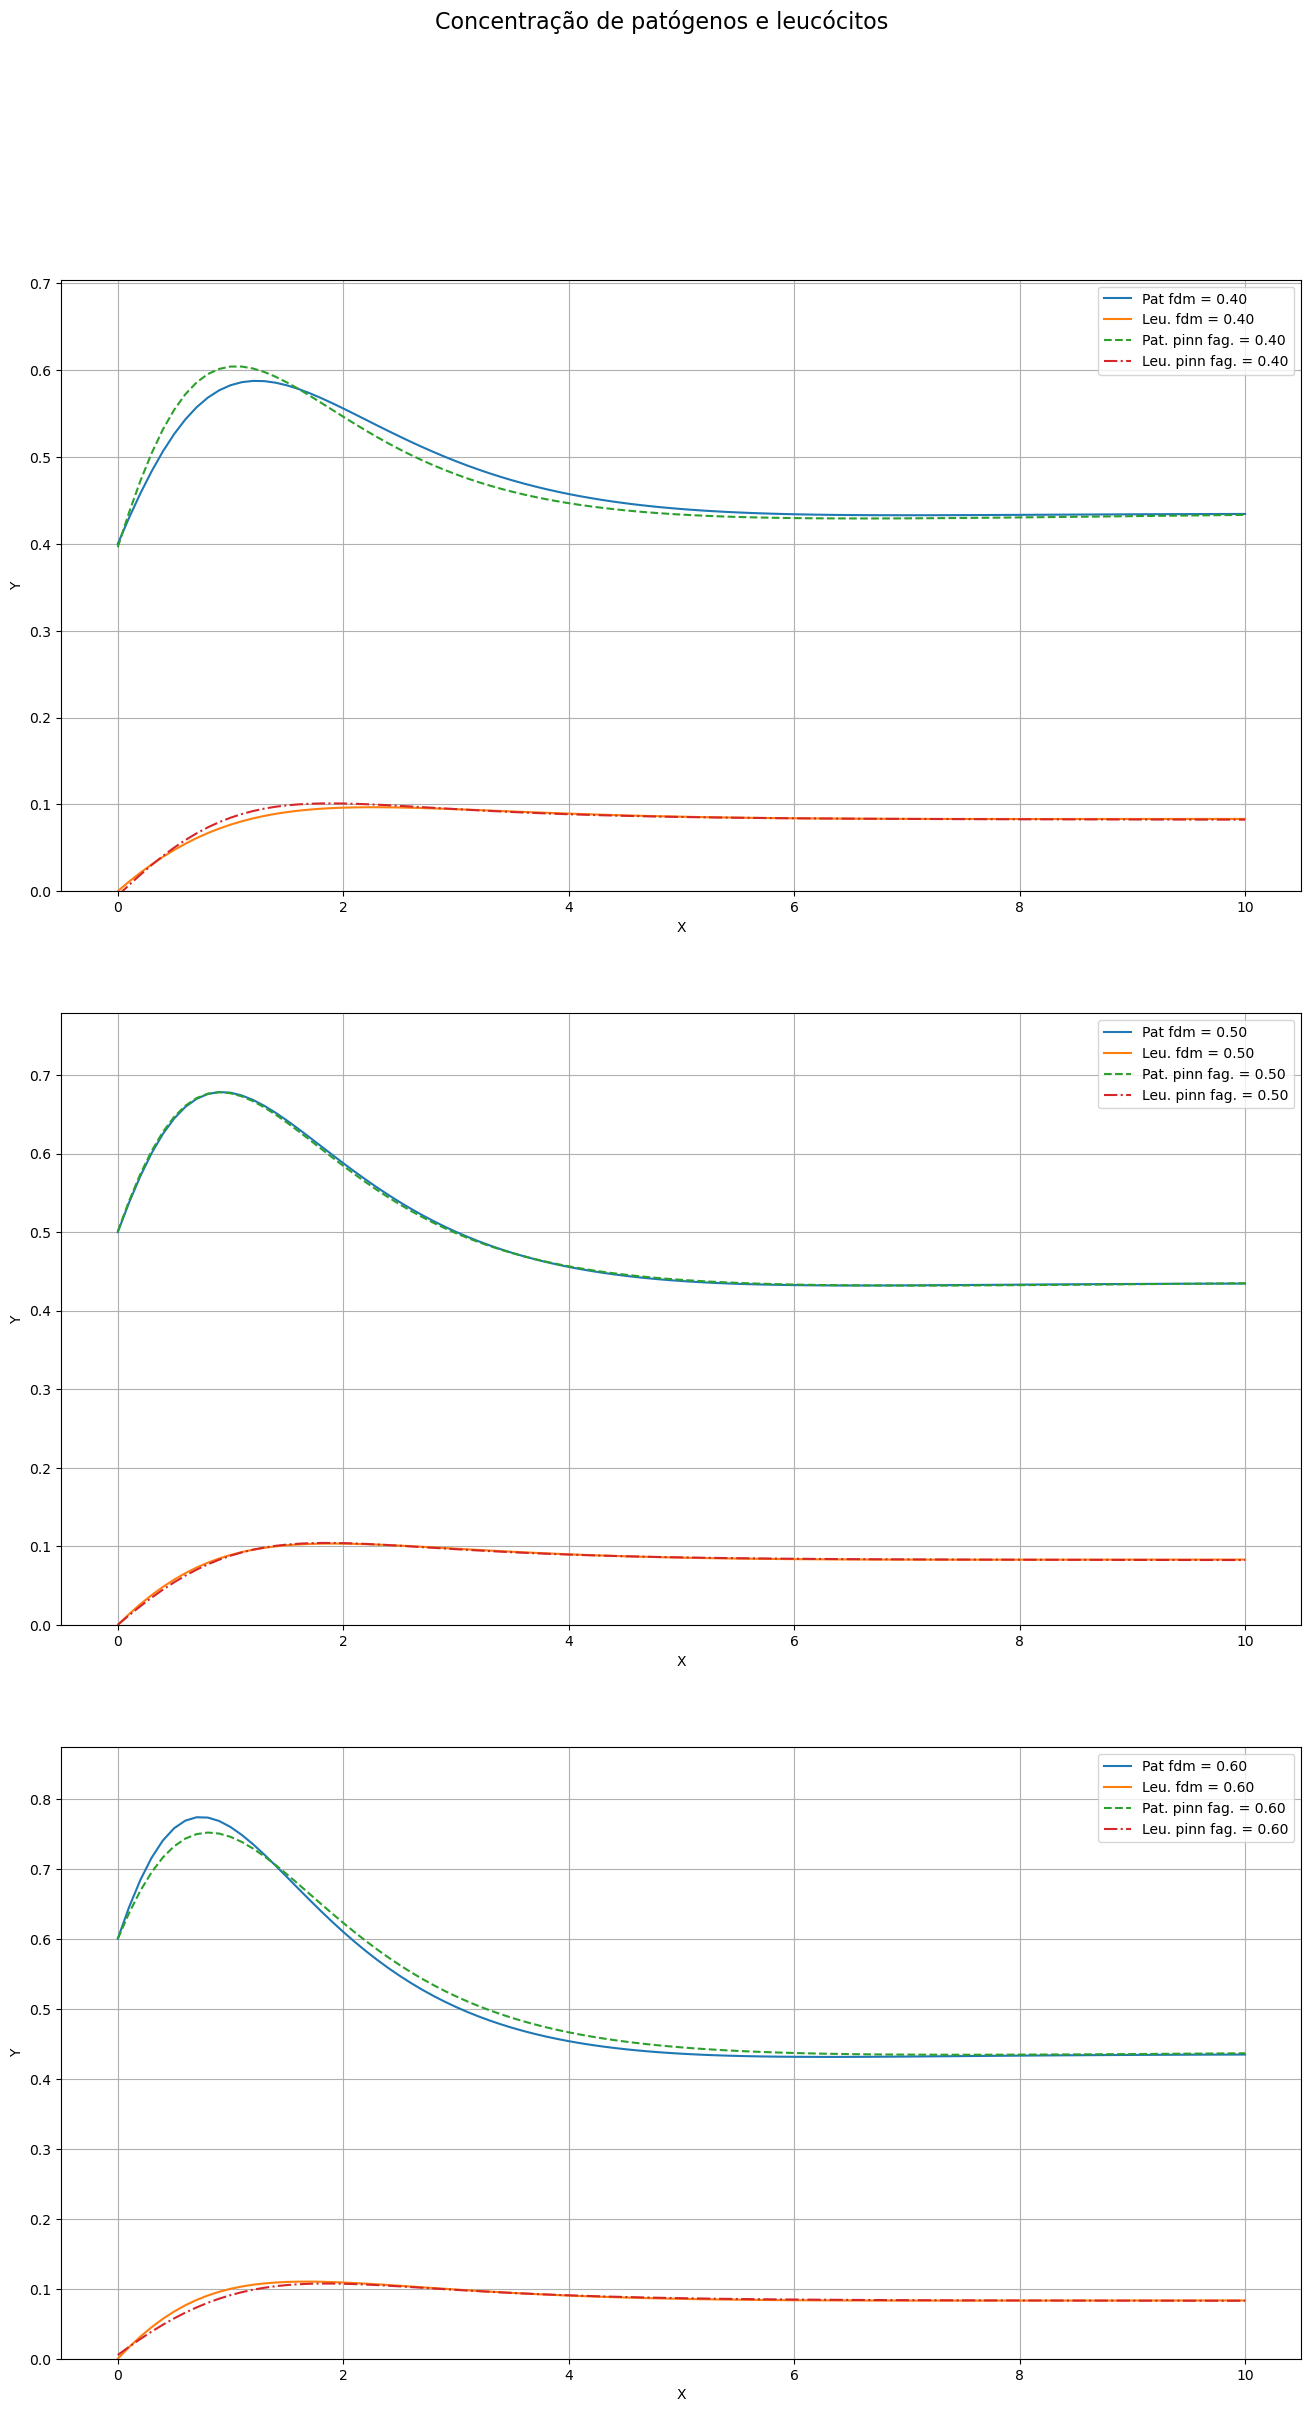

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp_old[0, :]
cl_real_1 = Cl_old[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
ini_1 = initial[0 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_2 = Cp_old[50, :]
cl_real_2 = Cl_old[50, :]
cp_pinn_2 = Cp_pinn_np[50, :]
cl_pinn_2 = Cl_pinn_np[50, :]
ini_2 = initial[50 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_3 = Cp_old[100, :]
cl_real_3 = Cl_old[100, :]
cp_pinn_3 = Cp_pinn_np[100, :]
cl_pinn_3 = Cl_pinn_np[100, :]
ini_3 = initial[100 * (size_t + 1)].cpu().detach().numpy()[0]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(ini_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(ini_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(ini_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(ini_2))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(ini_2))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(ini_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(ini_3))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(ini_3))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(ini_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()